In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

data = pd.read_csv('/content/drive/MyDrive/heart-disease.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# target sütununu hedef değişken yapma
X = data.drop(columns=['target'])
y = data['target']

# veri setini train ve test olarak ayırma
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# standardizasyon (ortalamalarını 0, standart sapmasını 1 yapar)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
# train ve test verilerini PyTorch DataLoader'larına dönüştürme
import torch
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

train_loader = DataLoader(TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                                         torch.tensor(y_train.values, dtype=torch.long)),
                          batch_size=batch_size, shuffle=True)

test_loader = DataLoader(TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                                        torch.tensor(y_test.values, dtype=torch.long)),
                         batch_size=batch_size)


In [4]:
# modeli tanımlama
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)  # dropout katmanı
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # dropout uygulanması
        x = self.fc2(x)
        return x

input_dim = X_train_scaled.shape[1]
hidden_dim = 64 # gizli katman
output_dim = 2  # binary classification için 2 sınıf
dropout_prob = 0.5  # dropout olasılığı

model = NeuralNetwork(input_dim, hidden_dim, output_dim, dropout_prob)



import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200


In [5]:
# Early Stopping sınıfının tanımlanması
class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [6]:
# Model eğitimi ve EarlyStopping mekanizması
losses = []
accuracies = []
early_stopping = EarlyStopping(patience=15, verbose=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

    early_stopping(epoch_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break


Epoch 1/200, Loss: 0.6845769711903164, Accuracy: 0.5566037735849056
Validation loss decreased (inf --> 0.684577).  Saving model ...
Epoch 2/200, Loss: 0.628010732786996, Accuracy: 0.6886792452830188
Validation loss decreased (0.684577 --> 0.628011).  Saving model ...
Epoch 3/200, Loss: 0.6033532534326825, Accuracy: 0.6839622641509434
Validation loss decreased (0.628011 --> 0.603353).  Saving model ...
Epoch 4/200, Loss: 0.5770725096975055, Accuracy: 0.7358490566037735
Validation loss decreased (0.603353 --> 0.577073).  Saving model ...
Epoch 5/200, Loss: 0.5227896315710885, Accuracy: 0.7688679245283019
Validation loss decreased (0.577073 --> 0.522790).  Saving model ...
Epoch 6/200, Loss: 0.523704822574343, Accuracy: 0.7830188679245284
EarlyStopping counter: 1 out of 15
Epoch 7/200, Loss: 0.484427205153874, Accuracy: 0.7830188679245284
Validation loss decreased (0.522790 --> 0.484427).  Saving model ...
Epoch 8/200, Loss: 0.4821510102067675, Accuracy: 0.7971698113207547
Validation loss

In [7]:
# modelin performansını değerlendirme
model.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.8241758241758241


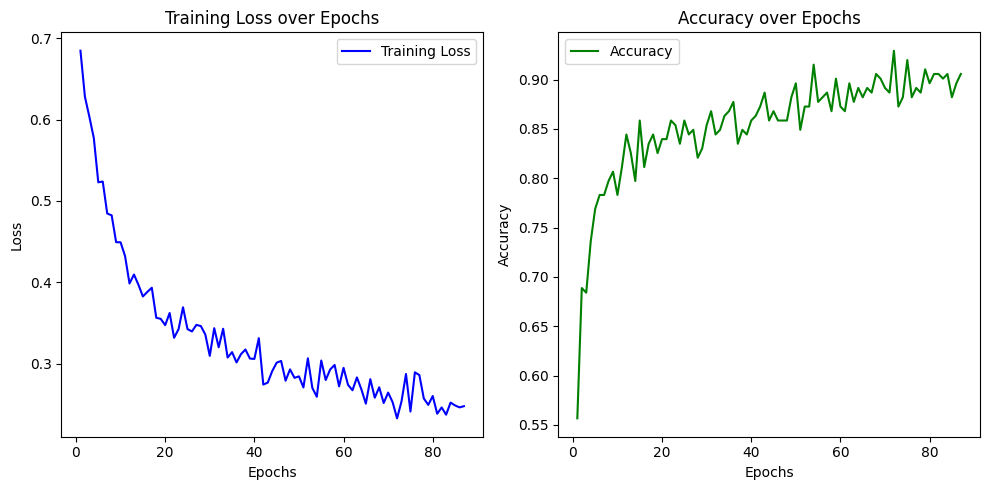

In [8]:
# loss ve accuracy grafiği
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses)+1), losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies)+1), accuracies, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


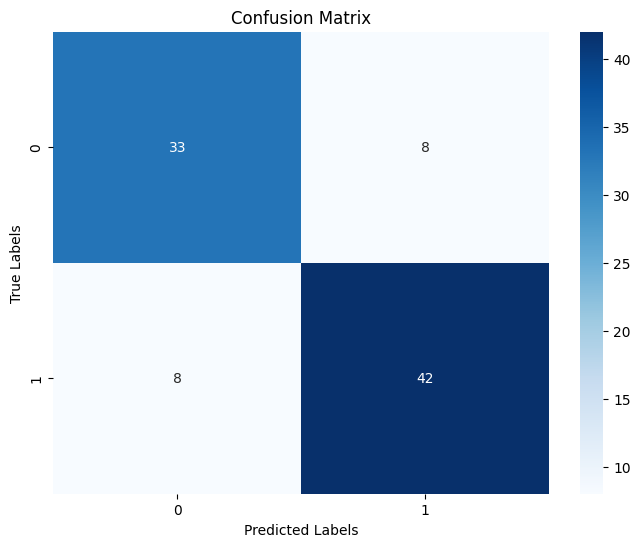

In [9]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(all_labels, all_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

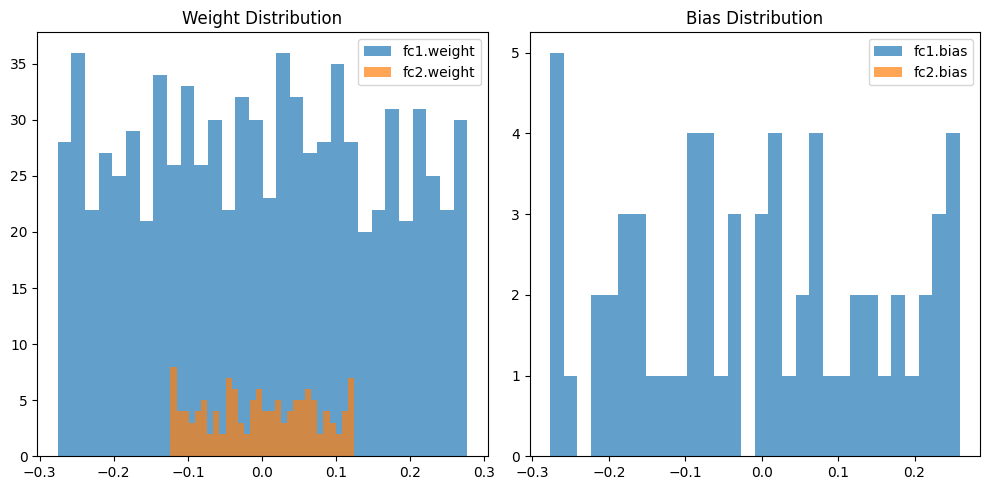

In [10]:
# Model Parametrelerinin Dağılımı Görselleştirme
def plot_model_parameters(model):
    plt.figure(figsize=(10, 5))
    for name, param in model.named_parameters():
        if 'weight' in name:
            plt.subplot(1, 2, 1)
            plt.hist(param.data.numpy().flatten(), bins=30, alpha=0.7, label=name)
            plt.title('Weight Distribution')
            plt.legend()
        elif 'bias' in name:
            plt.subplot(1, 2, 2)
            plt.hist(param.data.numpy().flatten(), bins=30, alpha=0.7, label=name)
            plt.title('Bias Distribution')
            plt.legend()
    plt.tight_layout()
    plt.show()

# Model parametrelerinin dağılımını görselleştirme
model = NeuralNetwork(input_dim=X_train_scaled.shape[1], hidden_dim=64, output_dim=2, dropout_prob=0.2)
plot_model_parameters(model)

# GNN

In [1]:
!pip install torch-geometric


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Veriyi yükleme ve işleme
data1 = pd.read_csv('/content/drive/MyDrive/heart-disease.csv')
X = data1.drop(columns=['target']).values.astype(np.float32)
y = data1['target'].values.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [4]:
# PyTorch Geometric veri yapısına dönüştürme
edge_index = torch.tensor([[0, 1, 2, 2, 3], [1, 0, 1, 3, 2]], dtype=torch.long)
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_data = Data(x=x_train_tensor, edge_index=edge_index, y=y_train_tensor)
test_data = Data(x=x_test_tensor, edge_index=edge_index, y=y_test_tensor)


In [5]:
# DataLoader'ları oluşturma
batch_size = 32
train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
test_loader = DataLoader([test_data], batch_size=batch_size)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# GNN modeli tanımlama
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout_prob = dropout_prob

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout_prob, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [7]:
# Modeli oluşturma ve ayarlar
input_dim = X_train.shape[1]  # Özellik sayısı
hidden_dim = 64
output_dim = 2  # Binary classification
dropout_prob = 0.2  # Dropout olasılığı
model = GNN(input_dim, hidden_dim, output_dim, dropout_prob)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [8]:
# Eğitim döngüsü
num_epochs = 500
loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.long())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(out, 1)
        total += data.y.size(0)
        correct += (predicted == data.y.long()).sum().item()

    loss_values.append(epoch_loss / len(train_loader))
    accuracy_values.append(correct / total)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss_values[-1]}, Accuracy: {accuracy_values[-1]}')


Epoch 0, Loss: 69.1627426147461, Accuracy: 0.45754716981132076
Epoch 10, Loss: 18.22944450378418, Accuracy: 0.4669811320754717
Epoch 20, Loss: 8.64314079284668, Accuracy: 0.6084905660377359
Epoch 30, Loss: 7.205349922180176, Accuracy: 0.5990566037735849
Epoch 40, Loss: 4.064486980438232, Accuracy: 0.5518867924528302
Epoch 50, Loss: 2.912928819656372, Accuracy: 0.6084905660377359
Epoch 60, Loss: 2.004495859146118, Accuracy: 0.6037735849056604
Epoch 70, Loss: 1.3094489574432373, Accuracy: 0.6556603773584906
Epoch 80, Loss: 0.7277097105979919, Accuracy: 0.7216981132075472
Epoch 90, Loss: 0.7625030875205994, Accuracy: 0.6745283018867925
Epoch 100, Loss: 0.5833113789558411, Accuracy: 0.7075471698113207
Epoch 110, Loss: 0.5865513682365417, Accuracy: 0.75
Epoch 120, Loss: 0.4896973669528961, Accuracy: 0.7735849056603774
Epoch 130, Loss: 0.4911234974861145, Accuracy: 0.7452830188679245
Epoch 140, Loss: 0.49646496772766113, Accuracy: 0.7641509433962265
Epoch 150, Loss: 0.5007916688919067, Accur

In [9]:
# Modelin performansını değerlendirme
model.eval()
all_predicted = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        out = model(data)
        _, predicted = torch.max(out, 1)
        all_predicted.extend(predicted.tolist())
        all_labels.extend(data.y.tolist())

# Doğruluk değerini hesaplayalım
correct = sum(1 for p, l in zip(all_predicted, all_labels) if p == l)
accuracy = correct / len(all_labels)
print("Accuracy:", accuracy)


Accuracy: 0.8021978021978022


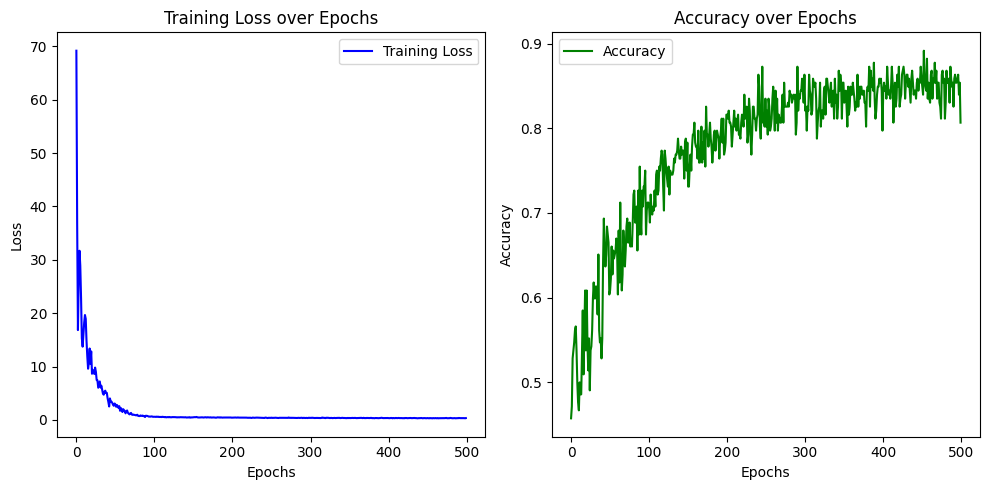

In [10]:

plt.figure(figsize=(10, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


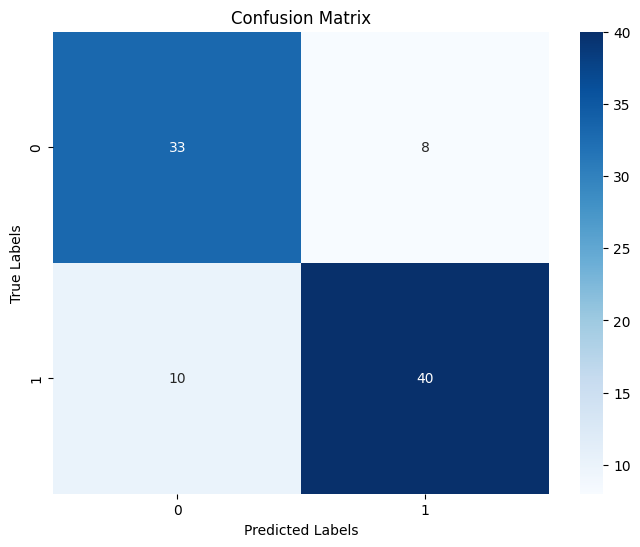

In [11]:
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
